# Solve 2d Poisson equation by PINN

---



### Domain:  $D=[0,1]^2$ 
### PDE
$$
\begin{aligned}
   \Delta u =& f\,\quad \mbox{in}\, D \\
   u|_{\partial D} =& g\quad \mbox{on}\, \partial D
   \end{aligned}
$$

### Aim: 
The boundary condition brings a constraint to the training task. 
The code below tests the splitting method in solving this PDE task. 

### Splitting method:

Suppose we want to solve
$$
    \min_{x} F(x), \quad s.t.\, G(x) = 0
$$

The splitting algorithm iterates two steps:

Step 1: Update $x^{n}$ to get $x^{n+1/2}$, using one-step update of the unconstrained optimization task:
$$
    \min_{x} F(x)
$$
Step 2: Starting from $x^{n+1/2}$, find $x^{n+1}$ by solving 
$$
    \min_{x} |G(X)|^2. 
$$ 


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import torch
import math 
import torch.nn as nn
import random
import itertools 
from tqdm import tqdm
import os
import time

In [2]:
def create_sequential_nn(layer_dims, activation=torch.nn.Tanh()):
    layers = torch.nn.Sequential()
    for i in range(len(layer_dims)-2) :
        layers.add_module(f'{i+1}',torch.nn.Linear(layer_dims[i], layer_dims[i+1])) 
        layers.add_module(f'acti {i+1}', activation)
    layers.add_module('last', torch.nn.Linear(layer_dims[-2], layer_dims[-1])) 
    return layers

In [3]:
class ConstrainedOptimizer():
    
    def __init__(self, model, g, optimizer, Y, batch_size=-1, res_tol=1e-3, max_iter_steps=100, verbose=True):
        self.g = g
        self.res_tol = res_tol
        self.max_iter_steps = max_iter_steps
        self.verbose = verbose
        self.model = model
        self.Y = Y       
        self.optimizer = optimizer
        self.batch_size = batch_size
        if batch_size > 0:
            rng = np.random.default_rng()
            
    def reset_data(self, Y):
        self.Y = Y
        
    def train(self):
        
        self.iter_steps = 0    
        loss_list = []
        while self.iter_steps < self.max_iter_steps:
            if self.batch_size > 0:
                batch_idx_Y = rng.integers(self.Y.shape[0], size=self.batch_size)
                Y_batch = torch.tensor(self.Y[batch_idx_Y, :]).float() 
            else :
                Y_batch = self.Y
                
            g_val = self.g(self.model, Y_batch)

            loss_list.append(g_val.detach().numpy())    
            
            if torch.linalg.norm(g_val) < self.res_tol:
                self.converged = True
                break
                
            self.optimizer.zero_grad()               
            g_val.backward()
            self.optimizer.step(lambda: self.g(self.model, Y_batch))
            self.iter_steps += 1
        return loss_list
    
    def is_succeed(self):
        return self.converged
    
    def total_iter_steps(self):
        return self.iter_steps

    def projection(self):
        return self.train()

In [8]:
from TestProblem import PoissonEqnByPINN

n = 10000
n_bndry = 1000

batch_size = 100
batch_size_bndry = 100


# total number of learning steps
num_iters = 2000

# layers of the neural network.
layer_dims = [2, 10, 1] 
optimizer_name = 'Adam'
learning_rate = 0.01

# create neural network that represents the solution of the PDE
model = create_sequential_nn(layer_dims)

problem = PoissonEqnByPINN(3.0, size=n, size_each_bndry=n_bndry)

train_losses = []
num_iters = 200
print ("\ntraining starts, %d iterations in total." % num_iters)

# prepare optimizer
if optimizer_name == 'Adam':
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
else:
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

c_optimizer = torch.optim.Adam(model.parameters(), lr=0.05)
#c_optimizer = torch.optim.SGD(model.parameters(), lr=0.05)       
#c_optimizer = torch.optim.LBFGS(model.parameters(), lr=0.05, history_size=10,tolerance_change=1e-3,
#                        max_iter=5, tolerance_grad=1e-03, line_search_fn="strong_wolfe")
    
copt = ConstrainedOptimizer(model, problem.G, c_optimizer, problem.get_Y(), batch_size=batch_size_bndry)

rng = np.random.default_rng()

for iter in tqdm(range(num_iters)):
    # Train the model by going through the whole dataset
    batch_idx_X = rng.integers(problem.get_X().shape[0], size=batch_size)

    X_batch = torch.tensor(problem.get_X()[batch_idx_X, :], requires_grad=True).float()
    
    # Step 1: minimize the PDE loss 
    optimizer.zero_grad()
    loss1 = problem.F(model, X_batch)
    loss1.backward()
    optimizer.step()
    # Step 2: projection by minimizing the boundary loss
    closs_list = copt.projection()       
    loss2 = closs_list[-1]
    loss3 = ((model(X_batch) - problem.ref_u(X_batch))**2).mean()
    csteps = copt.total_iter_steps()
    train_losses.append([loss1.detach().item(), loss2, loss3.detach().item(), csteps])
   


training starts, 200 iterations in total.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 379.32it/s]


/tmp/ipykernel_9772/1152534781.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  loss_list = np.array(train_losses)


Losses:


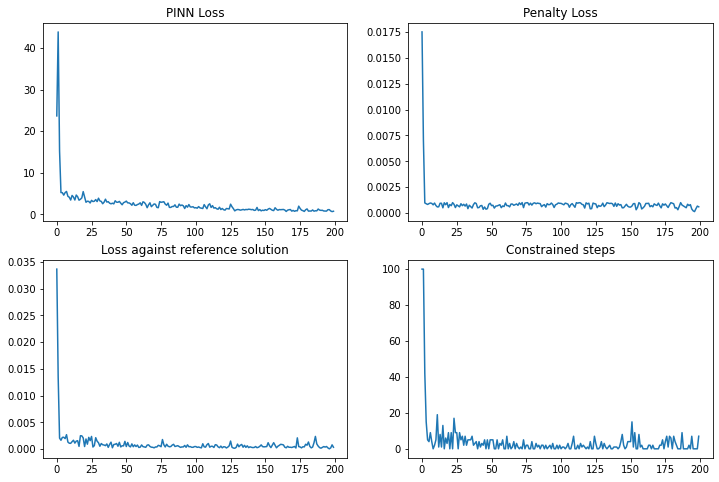

Solution u:


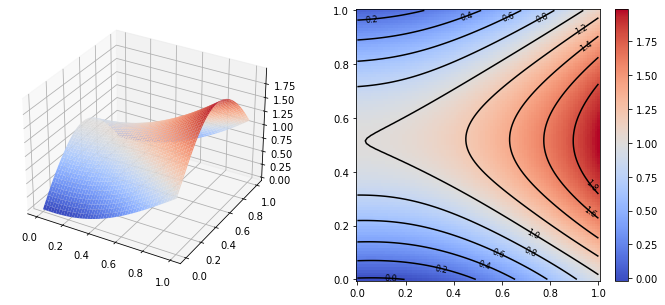

In [9]:
loss_list = np.array(train_losses)

ngrid = 100
grid1d = np.linspace(0, 1.0, ngrid)
x_plot = np.outer(grid1d, np.ones(ngrid)) 
y_plot = np.outer(grid1d, np.ones(ngrid)).T 

x2d = torch.from_numpy(np.concatenate((x_plot.reshape(ngrid * ngrid, 1), y_plot.reshape(ngrid * ngrid, 1)), axis=1)).float()
u = model(x2d).detach().numpy()

u = u.reshape(ngrid, ngrid)

print ('Losses:')
fig, ax = plt.subplots(2,2, figsize=(12,8))
ax[0,0].plot(loss_list[:,0])
ax[0,0].set_title('PINN Loss')
ax[0,1].plot(loss_list[:,1])
ax[0,1].set_title('Penalty Loss')
ax[1,0].plot(loss_list[:,2])
ax[1,0].set_title('Loss against reference solution')
ax[1,1].plot(loss_list[:,3])
ax[1,1].set_title('Constrained steps')

plt.show()
fig_name = f'losses.jpg'
#fig.savefig(fig_name)
plt.close()

print ('Solution u:')

fig = plt.figure(figsize=(12,5))
ax0 = fig.add_subplot(1, 2, 1, projection='3d')
ax1 = fig.add_subplot(1, 2, 2)  
ax0.plot_surface(x_plot, y_plot, u, cmap='coolwarm', edgecolor='none')
im = ax1.pcolormesh(x_plot, y_plot, u, cmap='coolwarm',shading='auto')
contours = ax1.contour(x_plot, y_plot, u, 10, colors='black')
ax1.clabel(contours, inline=False, fontsize=8)
fig.colorbar(im, ax=ax1)
fig_name = f'u.jpg'
#fig.savefig(fig_name)
plt.show()
#plt.close()
